In [1]:
import sys
sys.path.append(r'C:\Users\Gosia\Desktop\FDR-Metabolomics\src\passatutto_parser.py')
import passatutto_parser as pp

In [2]:
pre_spectrums = pp.parse_passatuto_folder(r'C:\Users\Gosia\Downloads\Gnps')

processed 100 files
processed 200 files
processed 300 files
processed 400 files
processed 500 files
processed 600 files
processed 700 files
processed 800 files
processed 900 files
processed 1000 files
processed 1100 files
processed 1200 files
processed 1300 files
processed 1400 files
processed 1500 files
processed 1600 files
processed 1700 files
processed 1800 files
processed 1900 files
processed 2000 files
processed 2100 files
processed 2200 files
processed 2300 files
processed 2400 files
processed 2500 files
processed 2600 files
processed 2700 files
processed 2800 files
processed 2900 files
processed 3000 files
processed 3100 files
processed 3200 files
processed 3300 files
processed 3400 files
processed 3500 files
processed 3600 files
processed 3700 files
processed 3800 files
processed 3900 files
processed 4000 files


In [3]:
from matchms.importing.load_from_json import as_spectrum
spectrums = []
for s in pre_spectrums:
    spectrums.append(as_spectrum(s))

In [4]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    return s

# apply filters to the data
spectrums = [post_process(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums if s is not None]

print("{} remaining spectra.".format(len(spectrums)))

4053 remaining spectra.


In [5]:
import bisect
import numpy as np
# a filter to check if there is a fragment within N ppm of the precursor
def has_frag(spectrum, mz, tol, tol_units='absolute'):
    if tol_units == 'ppm':
        di = tol_ppm*mz/1e6
    else:
        di = tol
    min_mz = mz - di
    max_mz = mz + di
    pos = bisect.bisect_right(spectrum.peaks[0], min_mz)
    pos2 = bisect.bisect_right(spectrum.peaks[0], max_mz)
    if pos == pos2:
        return None
    else:
        max_pos = pos + np.argmax(spectrum.peaks[1][pos:pos2])
        return (spectrum.peaks[0][max_pos], spectrum.peaks[1][max_pos])

In [6]:
spec_with_precursor = [s for s in spectrums if has_frag(s, s.metadata['precursor_mz'], 0.2)  is not None]

In [7]:
print(len(spec_with_precursor))

2682


In [8]:
inchi_dict = {}
for s in spec_with_precursor:
    ik = s.metadata['inchikey']
    if not ik in inchi_dict:
        inchi_dict[ik] = [s]
    else:
        inchi_dict[ik].append(s)

In [9]:
library_spec = set()
query_spec = set()
singletons = set([i for i,v in inchi_dict.items() if len(v) == 1])
multis = set([i for i,v in inchi_dict.items() if len(v) > 1])
print(len(singletons), len(multis))

1475 467


In [14]:
query_size = 400
library_size = 1000

In [15]:
used = set()
query_keys = np.random.choice(list(multis), size=query_size, replace=False)
other_library_keys = np.random.choice(list(singletons), size=library_size-query_size, replace=False)
query_spec = []
library_spec = []
for q in query_keys:
    ss = np.random.choice(inchi_dict[q], size=2, replace=False)
    query_spec.append(ss[0])
    library_spec.append(ss[1])
for o in other_library_keys:
    ss = np.random.choice(inchi_dict[o], size=1, replace=False)
    library_spec.append(ss[0])

assert len(library_spec) == library_size
assert len(query_spec) == query_size

In [59]:
# compute similarities between query and library spec

In [23]:
from matchms.similarity import CosineGreedy
cs = CosineGreedy()

In [24]:
library_spec.sort(key = lambda x: x.metadata['precursor_mz'])

In [25]:
def query(query_spec, library_spec, precursor_tol = 1):
    hits = []
    library_prec_list = [x.metadata['precursor_mz'] for x in library_spec]
    for q in query_spec:
        min_mz = q.metadata['precursor_mz'] - precursor_tol
        max_mz = q.metadata['precursor_mz'] + precursor_tol
        pos = bisect.bisect_right(library_prec_list, min_mz)
        pos2 = pos
        while library_prec_list[pos2]  < max_mz:
            pos2 += 1
        if pos == pos2:
            # nothing in precursor range
            hits.append((q, None, None))
        else:
            scores = []
            for l in library_spec[pos:pos2]:
                s,_ = cs.pair(l,q)
                scores.append((s, l))
            scores.sort(key = lambda x: x[0], reverse=True)
            hits.append((q, scores[0][0], scores[0][1]))
    return hits
hits = query(query_spec, library_spec)

In [27]:
hits = list(filter(lambda x: x[1] is not None, hits))
hits.sort(key = lambda x: x[1], reverse=True)
q,s,l = zip(*hits)

(array([ 10.,   8.,   4.,  11.,   9.,   6.,  13.,   6.,  10.,  10.,  13.,
         12.,  17.,  14.,  18.,  18.,  21.,  21.,  33., 133.]),
 array([0.        , 0.04997562, 0.09995123, 0.14992685, 0.19990247,
        0.24987809, 0.2998537 , 0.34982932, 0.39980494, 0.44978055,
        0.49975617, 0.54973179, 0.59970741, 0.64968302, 0.69965864,
        0.74963426, 0.79960987, 0.84958549, 0.89956111, 0.94953672,
        0.99951234]),
 <BarContainer object of 20 artists>)

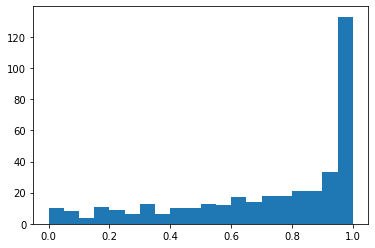

In [28]:
import pylab as plt
%matplotlib inline
plt.hist(s, bins=20)